In [1]:
%matplotlib inline


Station Plot with Layout
========================

Make a station plot, complete with sky cover and weather symbols, using a
station plot layout built into MetPy.

The station plot itself is straightforward, but there is a bit of code to perform the
data-wrangling (hopefully that situation will improve in the future). Certainly, if you have
existing point data in a format you can work with trivially, the station plot will be simple.

The `StationPlotLayout` class is used to standardize the plotting various parameters
(i.e. temperature), keeping track of the location, formatting, and even the units for use in
the station plot. This makes it easy (if using standardized names) to re-use a given layout
of a station plot.



The setup
---------

First read in the data. We use `numpy.loadtxt` to read in the data and use a structured
`numpy.dtype` to allow different types for the various columns. This allows us to handle
the columns with string data.



In [2]:
from awips.dataaccess import DataAccessLayer
from dynamicserialize.dstypes.com.raytheon.uf.common.time import TimeRange
from datetime import datetime, timedelta
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import pandas as pd

from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import (add_metpy_logo, simple_layout, StationPlot,
                         StationPlotLayout, wx_code_map)
from metpy.units import units

def get_cloud_cover(code):
    if 'OVC' in code:
        return 1.0
    elif 'BKN' in code:
        return 6.0/8.0
    elif 'SCT' in code:
        return 4.0/8.0
    elif 'FEW' in code:
        return 2.0/8.0
    else:
        return 0

# Pull out these specific stations (prepend K for AWIPS identifiers)
selected = ['PDX', 'OKC', 'ICT', 'GLD', 'MEM', 'BOS', 'MIA', 'MOB', 'ABQ', 'PHX', 'TTF',
            'ORD', 'BIL', 'BIS', 'CPR', 'LAX', 'ATL', 'MSP', 'SLC', 'DFW', 'NYC', 'PHL',
            'PIT', 'IND', 'OLY', 'SYR', 'LEX', 'CHS', 'TLH', 'HOU', 'GJT', 'LBB', 'LSV',
            'GRB', 'CLT', 'LNK', 'DSM', 'BOI', 'FSD', 'RAP', 'RIC', 'JAN', 'HSV', 'CRW',
            'SAT', 'BUY', '0CO', 'ZPC', 'VIH', 'BDG', 'MLF', 'ELY', 'WMC', 'OTH', 'CAR',
            'LMT', 'RDM', 'PDT', 'SEA', 'UIL', 'EPH', 'PUW', 'COE', 'MLP', 'PIH', 'IDA', 
            'MSO', 'ACV', 'HLN', 'BIL', 'OLF', 'RUT', 'PSM', 'JAX', 'TPA', 'SHV', 'MSY',
            'ELP', 'RNO', 'FAT', 'SFO', 'NYL', 'BRO', 'MRF', 'DRT', 'FAR', 'BDE', 'DLH',
            'HOT', 'LBF', 'FLG', 'CLE', 'UNV']
selected = ['K{0}'.format(id) for id in selected]
data_arr = []

In [3]:
# EDEX Request
edexServer = "edex-cloud.unidata.ucar.edu"
DataAccessLayer.changeEDEXHost(edexServer)
request = DataAccessLayer.newDataRequest("obs")
availableProducts = DataAccessLayer.getAvailableParameters(request)

single_value_params = ["timeObs", "stationName", "longitude", "latitude", 
                       "temperature", "dewpoint", "windDir",
                       "windSpeed", "seaLevelPress"]
multi_value_params = ["presWeather", "skyCover", "skyLayerBase"]
pres_weather, sky_cov, sky_layer_base = [],[],[]
params = single_value_params + multi_value_params
obs = dict({params: [] for params in params})

request.setParameters(*(params))
request.setLocationNames(*(selected))

Here we use the Python-AWIPS class **TimeRange** to prepare a beginning and end time span for requesting observations (the last hour):

In [4]:
# Time range
lastHourDateTime = datetime.utcnow() - timedelta(hours = 1)
start = lastHourDateTime.strftime('%Y-%m-%d %H')
beginRange = datetime.strptime( start + ":00:00", "%Y-%m-%d %H:%M:%S")
endRange = datetime.strptime( start + ":59:59", "%Y-%m-%d %H:%M:%S")
timerange = TimeRange(beginRange, endRange)

response = DataAccessLayer.getGeometryData(request,timerange)

In [6]:
station_names = []
for ob in response:
    avail_params = ob.getParameters()
    if "presWeather" in avail_params:
        pres_weather.append(ob.getString("presWeather"))
    elif "skyCover" in avail_params and "skyLayerBase" in avail_params:
        sky_cov.append(ob.getString("skyCover"))
        sky_layer_base.append(ob.getNumber("skyLayerBase"))
    else:
        # If we already have a record for this stationName, skip
        if ob.getString('stationName') not in station_names:
            station_names.append(ob.getString('stationName'))
            for param in single_value_params:            
                if param in avail_params:
                    if param == 'timeObs':
                        obs[param].append(datetime.fromtimestamp(ob.getNumber(param)/1000.0))
                    else:
                        try:
                            obs[param].append(ob.getNumber(param))
                        except TypeError:
                            obs[param].append(ob.getString(param))
                else:
                    obs[param].append(None)
        
            obs['presWeather'].append(pres_weather);
            obs['skyCover'].append(sky_cov);
            obs['skyLayerBase'].append(sky_layer_base);
            pres_weather = []
            sky_cov = []
            sky_layer_base = []

Next grab the simple variables out of the data we have (attaching correct units), and
put them into a dictionary that we will hand the plotting function later:

- Get wind components from speed and direction
- Convert cloud fraction values to integer codes [0 - 8]
- Map METAR weather codes to WMO codes for weather symbols

In [7]:
data = dict()
data['stid'] = np.array(obs['stationName'])
data['latitude']  = np.array(obs['latitude'])
data['longitude'] = np.array(obs['longitude'])
data['air_temperature'] = np.array(obs['temperature'], dtype=float)* units.degC
data['dew_point_temperature'] = np.array(obs['dewpoint'], dtype=float)* units.degC
data['air_pressure_at_sea_level'] = np.array(obs['seaLevelPress'])* units('mbar')

direction = np.array(obs['windDir'])
direction[direction == -9999.0] = 'nan'

u, v = wind_components(np.array(obs['windSpeed']) * units('knots'),
                           direction * units.degree)
data['eastward_wind'], data['northward_wind'] = u, v
data['cloud_coverage'] = [int(get_cloud_cover(x)*8) for x in obs['skyCover']]
data['present_weather'] = obs['presWeather']

In [8]:
print(obs['stationName'])

['K0CO', 'KNYC', 'KMLF', 'KACV', 'KHLN', 'KBDE', 'KLBF', 'KJAN', 'KBOI', 'KCPR', 'KGRB', 'KPDX', 'KATL', 'KCLT', 'KTTF', 'KJAX', 'KMLP', 'KSAT', 'KSHV', 'KOLY', 'KGLD', 'KBDG', 'KICT', 'KCAR', 'KFAR', 'KPDT', 'KSEA', 'KLNK', 'KMIA', 'KORD', 'KPHX', 'KPIT', 'KCLE', 'KELP', 'KOKC', 'KOLF', 'KRAP', 'KBIS', 'KGJT', 'KIDA', 'KDFW', 'KHOT', 'KHOU', 'KBRO', 'KABQ', 'KMSP', 'KMSY', 'KPIH', 'KLMT', 'KTPA', 'KPUW', 'KUNV', 'KVIH', 'KEPH', 'KMSO', 'KLAX', 'KLBB', 'KUIL', 'KTLH', 'KDRT', 'KELY', 'KFAT', 'KHSV', 'KBOS', 'KMRF', 'KRUT', 'KIND', 'KSLC', 'KPHL', 'KCOE', 'KRNO', 'KCRW', 'KDSM', 'KSYR', 'KRIC', 'KLEX', 'KOTH', 'KBUY', 'KMEM', 'KNYL', 'KFSD', 'KCHS', 'KSFO', 'KMOB', 'KRDM', 'KWMC', 'KFLG', 'KPSM', 'KLSV', 'KBIL']


## MetPy Surface Obs Plot

/Users/mjames/miniconda3/envs/python3-awips/lib/python3.6/site-packages/metpy/plots/station_plot.py:299: RuntimeWarning: invalid value encountered in less
  u, v = self.ax.projection.transform_vectors(trans, self.x, self.y, u, v)
/Users/mjames/miniconda3/envs/python3-awips/lib/python3.6/site-packages/metpy/plots/station_plot.py:299: RuntimeWarning: invalid value encountered in greater
  u, v = self.ax.projection.transform_vectors(trans, self.x, self.y, u, v)


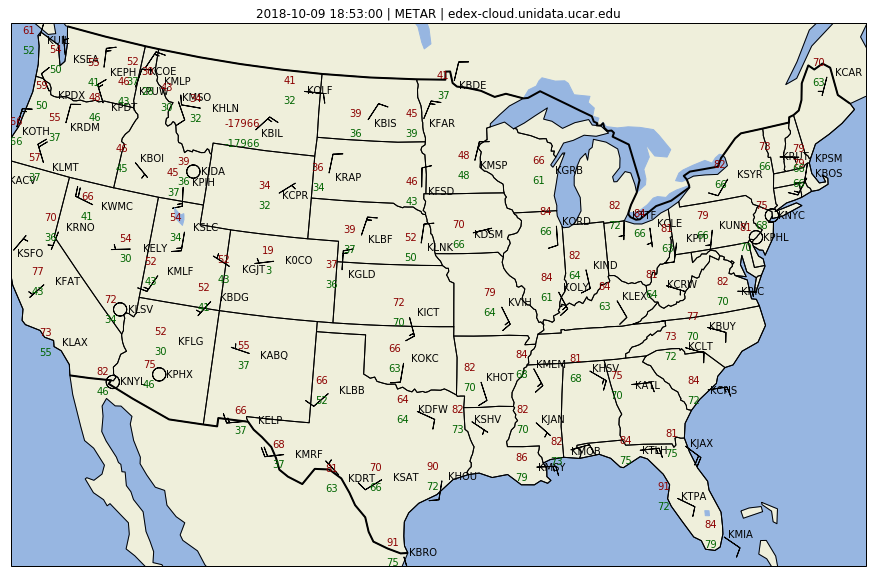

In [9]:
proj = ccrs.LambertConformal(central_longitude=-95, central_latitude=35,
                             standard_parallels=[35])

# Change the DPI of the figure
plt.rcParams['savefig.dpi'] = 255

# Winds, temps, dewpoint, station id
custom_layout = StationPlotLayout()
custom_layout.add_barb('eastward_wind', 'northward_wind', units='knots')
custom_layout.add_value('NW', 'air_temperature', fmt='.0f', units='degF', color='darkred')
custom_layout.add_value('SW', 'dew_point_temperature', fmt='.0f', units='degF', color='darkgreen')
custom_layout.add_value('E', 'precipitation', fmt='0.1f', units='inch', color='blue')

# Create the figure
fig = plt.figure(figsize=(20, 10))
add_metpy_logo(fig, 1080, 290, size='large')
ax = fig.add_subplot(1, 1, 1, projection=proj)

# Add various map elements
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.BORDERS, linewidth=2)

# Set plot bounds
ax.set_extent((-118, -73, 23, 50))
ax.set_title(str(ob.getDataTime()) + " | METAR | " + edexServer)

stationplot = StationPlot(ax, data['longitude'], data['latitude'], clip_on=True,
                          transform=ccrs.PlateCarree(), fontsize=10)
stationplot.plot_text((2, 0), data['stid'])
custom_layout.plot(stationplot, data)
plt.show()